In [211]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from arch import arch_model
import mgarch
from datetime import date
from joblib import Parallel, delayed
from matplotlib import pyplot as plt

In [212]:
Bank_data = pd.read_csv("Bank_data_full_2.csv")
Bank_data = Bank_data.drop(['PERMNO','PERMCO'], axis = 1)

Bank_data_other = pd.read_csv("Bank_data_full_2.csv")
Bank_data_other = Bank_data_other.drop(['PERMNO','PERMCO'], axis = 1)



SP_index = pd.read_csv("SP_500_Data.csv")
sector_data = pd.read_csv("48_Industry_Portfolios_Daily.csv")
sector_data = sector_data.rename(columns={sector_data.columns[0]:'Date'})
sector_data.head()

sector_data.iloc[:, 0] = pd.to_datetime(sector_data.iloc[:, 0].astype(str), format='%Y%m%d', errors='coerce')

sector_data = sector_data[['Date','Aero', 'Guns', 'Ships','Oil', 'Coal', 'Util']].copy()

sector_data = sector_data.loc[:26132]




/var/folders/0q/vd9_j4p16sxdmvrf02mwf33m0000gn/T/ipykernel_92927/2074775263.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  Bank_data = pd.read_csv("Bank_data_full_2.csv")
/var/folders/0q/vd9_j4p16sxdmvrf02mwf33m0000gn/T/ipykernel_92927/2074775263.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  Bank_data_other = pd.read_csv("Bank_data_full_2.csv")
/var/folders/0q/vd9_j4p16sxdmvrf02mwf33m0000gn/T/ipykernel_92927/2074775263.py:10: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  sector_data = pd.read_csv("48_Industry_Portfolios_Daily.csv")


In [213]:
Bank_data_other['Market_Cap'] = Bank_data_other['PRC'].values*Bank_data_other['SHROUT'].values


In [214]:
sector_data.set_index('Date', inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexes/base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [215]:
sector_data = sector_data.sort_index()
sector_data = sector_data[ (sector_data.index >= '2000-01-03') & (sector_data.index <= '2024-12-31') ].copy()


In [216]:

SP_index = SP_index.rename(columns={'caldt':'Date','sprtrn': 'Ret'})

SP_index.set_index('Date', inplace=True)

In [217]:
SP_index = SP_index.sort_index()

SP_index = SP_index[ (SP_index.index >= '2000-01-03') & (SP_index.index <= '2024-12-31') ].copy()

In [218]:
sector_data = sector_data.apply(pd.to_numeric, errors='coerce')

In [219]:
Defence_index = pd.DataFrame()
Energy_index = pd.DataFrame()

Defence_index = 1/3*sector_data['Aero'].values+1/3*sector_data['Guns'].values+1/3*sector_data['Ships'].values
Energy_index = 1/3*sector_data['Oil'].values+1/3*sector_data['Coal'].values+1/3*sector_data['Util'].values

In [220]:
Defence_index  = pd.DataFrame(Defence_index, index = sector_data.index)

Energy_index = pd.DataFrame(Energy_index,index=sector_data.index)

Defence_index = Defence_index
Energy_index = Energy_index
Energy_index.head()

,0
Date,
2000-01-03,-0.773333
2000-01-04,-2.586667
2000-01-05,1.183333
2000-01-06,0.460000
2000-01-07,1.623333


In [221]:
SP_index.columns

Index(['Ret'], dtype='object')

In [222]:
Geo_Pol_long = pd.DataFrame()
Geo_Pol_short = pd.DataFrame()
Geo_Pol_index = pd.DataFrame()

Geo_Pol_long = 0.5*Defence_index.values+0.5*Energy_index.values # in percentage
Geo_Pol_long = pd.DataFrame(Geo_Pol_long, index = Energy_index.index)

Geo_Pol_short = -SP_index.values*100 # from decimal to percentage


In [223]:
Geo_Pol_index = Geo_Pol_long+Geo_Pol_short


In [224]:
Bank_data['date'] = pd.to_datetime(Bank_data['date'])
Bank_data.set_index('date', inplace=True)

In [225]:
Bank_data_other['date'] = pd.to_datetime(Bank_data_other['date'])
Bank_data_other.set_index('date', inplace=True)

In [226]:
Bank_data= Bank_data.sort_index()

Bank_data = Bank_data[ (Bank_data.index >= '2000-01-03') & (Bank_data.index <= '2024-12-31') ].copy()

In [227]:
Bank_data_other = Bank_data_other.sort_index()

Bank_data_other = Bank_data_other[ (Bank_data_other.index >= '2000-01-03') & (Bank_data_other.index <= '2024-12-31') ].copy()

In [228]:

Bank_data = {ticker: group for ticker, group in Bank_data.groupby('TICKER')}

In [229]:

Bank_data_other = {ticker: group for ticker, group in Bank_data_other.groupby('TICKER')}


In [230]:
X = np.column_stack([SP_index.values, Geo_Pol_index.values])
X = sm.add_constant(X)


results = {}




In [231]:
for ticker,y in Bank_data.items():

    if len(y)==len(SP_index):

        ys = y['RET'].astype(float).values
        X_ = X.astype(float)
        model = sm.OLS(ys, X).fit()
        results[ticker] = model





In [ ]:
market_caps = [np.mean(y['Market_Cap']) for y in Bank_data_other.values()]
threshold = np.percentile(market_caps, 90)
print("Market Cap threshold for top 10% banks:", threshold)

Market Cap threshold for top 20% banks: 1479820.0941611968


In [233]:
results_other = {}
for ticker,y in Bank_data_other.items():
    if len(y)==len(SP_index)and np.mean(y['Market_Cap'])>threshold:
        ys = y['RET'].astype(float).values
        X_ = X.astype(float)
        model = sm.OLS(ys, X_).fit()
        results_other[ticker] = model

In [234]:
neg_x2 = {}

x2_idx = 2
for ticker, model in results.items():

    x2_coef = model.params[x2_idx]
    x2_tval = model.tvalues[x2_idx]

    if x2_coef < 0 and np.abs(x2_tval) > 2 :
        neg_x2[ticker] = {
            'x2_coef': x2_coef,
            'x2_tvalue': x2_tval,
            'results': model.summary()
        }

for ticker, vals in neg_x2.items():
    print(ticker, vals['x2_coef'], vals['x2_tvalue'],'\n', vals['results'])

In [235]:
neg_x2_other = {}

for ticker, model in results_other.items():

    x2_coef = model.params[x2_idx]
    x2_tval = model.tvalues[x2_idx]

    if x2_coef < 0 and np.abs(x2_tval) > 2 :
        neg_x2_other[ticker] = {
            'x2_coef': x2_coef,
            'x2_tvalue': x2_tval
        }

for ticker, vals in neg_x2_other.items():
    print(ticker, vals['x2_coef'], vals['x2_tvalue'])

# Prepare Exog neg returns Indicator 

In [236]:
r_minus = [i if i < 0 else 0 for i in SP_index['Ret']]

# Prepare GPR index from monthly data (test instead of current index)

In [237]:
# create gpr_t_index_monthly by taking only the month columnn and GPRT column from gpr_data
gpr_data = pd.read_csv("data_gpr_export.csv")
gpr_data['Date'] = pd.to_datetime(gpr_data['month'], format='%d/%m/%Y')
gpr_t_index_monthly = gpr_data[['Date', 'GPRT']].copy()
gpr_t_index_monthly.set_index('Date', inplace=True)

In [238]:
gpr_t_index_monthly = gpr_t_index_monthly[
    (gpr_t_index_monthly.index >= '1999-12-01') & 
    (gpr_t_index_monthly.index <= '2010-01-31')    
]

In [239]:
# interpolate monthly data to daily data 
gpr_t_index_daily = gpr_t_index_monthly.resample('D').ffill()

In [240]:
# match gpr dates to SP_index dates
gpr_t_index_daily = gpr_t_index_daily.loc[gpr_t_index_daily.index.isin(SP_index.index)]

/var/folders/0q/vd9_j4p16sxdmvrf02mwf33m0000gn/T/ipykernel_92927/726057541.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  gpr_t_index_daily = gpr_t_index_daily.loc[gpr_t_index_daily.index.isin(SP_index.index)]


In [241]:
gpr_t_index_daily['GPRT_change'] = gpr_t_index_daily['GPRT'].diff().fillna(0)
gpr_t_index_daily.head()

,GPRT,GPRT_change
Date,,
2000-01-03,65.57,0.0
2000-01-04,65.57,0.0
2000-01-05,65.57,0.0
2000-01-06,65.57,0.0
2000-01-07,65.57,0.0


# Prepare log returns + scaling

In [242]:
# scaling 
scale_i = 100  # log(1+r)*10 ≈ r*10
scale_mkt = 1  # S&P 500 return without scaling
scale_r_m = 100 # negative market return *100
# scale_g = 100 


In [246]:
# data prep 

for ticker ,y in Bank_data_other.items():
    y['RET'] = pd.to_numeric(y['RET'], errors='coerce')
    y['RET'] = y['RET'].interpolate(method='linear', limit=2) 
    y['RET'] = y['RET'].fillna(0.0)
    y['logRET'] = np.log1p((y['RET'].copy()).astype(float).values)
    y['logRET'] = y['logRET']*scale_i
    Bank_data[ticker]['logRET'] = y['logRET']

# DCB 

In [ ]:

Bank_data_filtered = { #filtered for market cap and length
    ticker: data 
    for ticker, data in Bank_data_other.items()
    if ticker in Bank_data_other 
    and len(data) == len(SP_index)
    and np.mean(Bank_data_other[ticker]['Market_Cap']) > threshold
}

# Garch GJR

In [248]:
r_minus = [i if i < 0 else 0 for i in SP_index['Ret']]

x = r_minus.copy()
x = np.array(x) * scale_r_m
x = sm.add_constant(x)

sigma_i = {}
res_i = {} 
z_i = {}

for ticker,y in Bank_data_filtered.items():
    if len(y)==len(r_minus):
        ys = y['logRET'].values
        model_i = arch_model(ys,x, vol='Garch', p=1, q=1)
        res_i[ticker] = model_i.fit(disp='off')
        sigma_i[ticker] = res_i[ticker].conditional_volatility
        z_i[ticker] = res_i[ticker].resid / sigma_i[ticker]
        
rm = SP_index['Ret'].values * scale_mkt
model_m = arch_model(rm,x, vol='Garch', p=1, q=1)
res_m = model_m.fit(disp='off')
sigma_m = res_m.conditional_volatility
z_m = res_m.resid / sigma_m

fgeo = Geo_Pol_index.values
# fgeo = np.log(gpr_t_index_daily['GPRT']).diff().fillna(0).values * scale_g # get log diffs
model_geo = arch_model(fgeo, x, vol='Garch', p=1, q=1)
res_geo = model_geo.fit(disp='off')
sigma_geo = res_geo.conditional_volatility
z_geo = res_geo.resid / sigma_geo




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001492. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


# DCC to get a,b for each firm

In [249]:
def extract_R_t(model, a, b):
    a = a
    b = b
    D_t = model.D_t  # T x N conditional volatilities
    rt = model.rt    # T x N returns (mean-centered)
    T = rt.shape[0]
    N = rt.shape[1]
    
    Q_bar = np.cov(rt.T)  # Long-run correlation
    Q_t = np.zeros((T, N, N))
    R_t = np.zeros((T, N, N))
    
    Q_t[0] = np.matmul(rt[0].T / 2, rt[0] / 2)
    
    for i in range(1, T):
        dts = np.diag(D_t[i])
        dtinv = np.linalg.inv(dts)
        et = dtinv @ rt[i].T  # Standardized residuals
        
        Q_t[i] = (1 - a - b) * Q_bar + a * (et * et.T) + b * Q_t[i - 1]
        qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))
        
        R_t[i] = qts @ Q_t[i] @ qts  # Normalized correlation
    
    return R_t  # T x N x N array of correlation matrices

def fit_mgarch_for_ticker(ticker, z_i, z_m, z_geo):
    """Fit MGARCH model for a single ticker."""
    z_stack = np.column_stack([z_i[ticker], z_m, z_geo])
    mgarch_model = mgarch.mgarch()
    mgarch_model.fit(returns=z_stack)
    return ticker, mgarch_model, mgarch_model.a, mgarch_model.b


def compute_R_t_for_ticker(ticker, model, a_median, b_median):
    """Compute R_t for a single ticker."""
    R_t = extract_R_t(model, a=a_median, b=b_median)
    return ticker, R_t

In [250]:
tickers = list(Bank_data_filtered.keys())
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(fit_mgarch_for_ticker)(ticker, z_i, z_m, z_geo)
    for ticker in tickers
)

models = {}
a_s = []
b_s = []
for ticker, model, a, b in results:
    models[ticker] = model
    a_s.append(a)
    b_s.append(b)

# Calculate medians
a_median = np.median(a_s)
b_median = np.median(b_s)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mgarch/mgarch.py:65: RuntimeWarning: invalid value encountered in log
  np.log(np.linalg.det(R_t[i])) + \
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mgarch/mgarch.py:65: RuntimeWarning: invalid value encountered in log
  np.log(np.linalg.det(R_t[i])) + \
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mgarch/mgarch.py:56: RuntimeWarning: invalid value encountered in sqrt
  qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mgarch/mgarch.py:65: RuntimeWarning: invalid value encountered in lo

In [251]:
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(compute_R_t_for_ticker)(ticker, models[ticker], a_median, b_median)
    for ticker in tickers
)

# Convert results to dictionary
R_t_dict = dict(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:    1.4s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    2.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    2.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    2.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    3.3s finished


In [252]:
def compute_beta_t(ticker, R_t_dict, sigma_i, sigma_m, sigma_geo):
    """Compute beta_t for a single ticker."""
    R = R_t_dict[ticker]
    rho_im = R[:, 0, 1]
    rho_ig = R[:, 0, 2]
    rho_mg = R[:, 1, 2]

    T = R.shape[0]

    sigma_i_aligned = sigma_i[ticker][-T:]
    sigma_m_aligned = sigma_m[-T:]
    sigma_geo_aligned = sigma_geo[-T:]

    Sigma_FF = np.zeros((T, 2, 2))
    Sigma_FF[:, 0, 0] = sigma_m_aligned**2
    Sigma_FF[:, 1, 1] = sigma_geo_aligned**2
    Sigma_FF[:, 0, 1] = rho_mg * sigma_m_aligned * sigma_geo_aligned
    Sigma_FF[:, 1, 0] = Sigma_FF[:, 0, 1]

    Sigma_iF = np.zeros((T, 2))
    Sigma_iF[:, 0] = rho_im * sigma_i_aligned * sigma_m_aligned      # Cov(ticker, market)
    Sigma_iF[:, 1] = rho_ig * sigma_i_aligned * sigma_geo_aligned    # Cov(ticker, geo)

    beta_t_ticker = np.zeros((T, 2))
    for t in range(T):
        beta_t_ticker[t, :] = np.linalg.solve(Sigma_FF[t], Sigma_iF[t])

    return ticker, beta_t_ticker

In [253]:
results = Parallel(n_jobs=-1, verbose=1)(
    delayed(compute_beta_t)(ticker, R_t_dict, sigma_i, sigma_m, sigma_geo)
    for ticker in tickers
)

beta_t_dict = {ticker: beta for ticker, beta in results}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.0s finished


In [280]:
# beta_t_dict['BAC'][:,1]

# G-RISK

In [255]:
Dashboard_data = pd.read_csv("Dashboard_data_2.csv")
Dashboard_data = Dashboard_data[['tic','datadate','dlcq','dlttq']]
Dashboard_data['Book Leverage'] = Dashboard_data['dlcq']+Dashboard_data['dlttq']


In [256]:
dashboard_dict = {}
for tic, group in Dashboard_data.groupby('tic'):
    df = group.drop(columns='tic')
    df = df.set_index('datadate')
    dashboard_dict[tic] = df

In [257]:
ticker_dict = {}

for ticker in dashboard_dict.keys() & Bank_data_filtered.keys()& z_i.keys():
    marketcap = Bank_data_filtered[ticker]['Market_Cap']
    leverage = dashboard_dict[ticker]['Book Leverage']
    leverage.index = pd.to_datetime(leverage.index)
    marketcap.index = pd.to_datetime(marketcap.index)
    # Forward-fill the quarterly leverage to daily dates
    leverage_daily = leverage.reindex(marketcap.index, method='ffill')

    # Combine into one DataFrame
    combined = pd.concat([marketcap, leverage_daily], axis=1)
    combined.columns = ['marketcap', 'leverage']

    ticker_dict[ticker] = combined
    ticker_dict[ticker] = ticker_dict[ticker].dropna()


In [258]:
# scale all betas in the second column of beta_t_dict by 1/100
for ticker in beta_t_dict.keys():
    beta_t_dict[ticker][:, 1] = beta_t_dict[ticker][:, 1] /100

In [259]:
# create a df only with the second column of betas and index is date from Bank_data_filtered
beta_i_geo = {}
for ticker in beta_t_dict.keys():
    beta_i_geo[ticker] = pd.DataFrame(beta_t_dict[ticker][:, 1], index = Bank_data_filtered[ticker].index)
    beta_i_geo[ticker].index = beta_i_geo[ticker].index.date
    beta_i_geo[ticker] = beta_i_geo[ticker].rename_axis('date')
    beta_i_geo[ticker] = beta_i_geo[ticker][beta_i_geo[ticker].index >= date(2000, 3, 31)]
    # beta_i_geo[ticker].columns = ['Date','Beta_Geo']
    # beta_i_geo[ticker].index = pd.to_datetime(Bank_data_filtered[ticker].index, format='%Y-%m-%d').date


# G-Risk stress test


In [260]:
Geo_Pol_index.index = pd.to_datetime(Geo_Pol_index.index)

factor_price = (1 + Geo_Pol_index / 100).cumprod()
six_month_factor_return = factor_price / factor_price.shift(126) - 1

top_1pct = six_month_factor_return.quantile(0.99)
print("Top 1% 6-month return:", top_1pct)

Top 1% 6-month return: 0    0.471028
Name: 0.99, dtype: float64


In [261]:
def calculate_georisk(ticker,ticker_dict, beta_geo_rescaled, top_1pct, k=0.08):
    exponent = beta_geo_rescaled[ticker] * np.log(1 + top_1pct)

    Loss = np.exp(exponent)

    leverage = ticker_dict[ticker]['leverage']
    marketcap = ticker_dict[ticker]['marketcap']
    Georisk = k * leverage - (1 - k) * marketcap * Loss[0]

    MGeorisk = (1 - k) * marketcap * Loss[0]

    return Georisk, MGeorisk


In [262]:
Georisk_dict = {}
MGeorisk_dict = {}
for ticker in ticker_dict.keys():
    Georisk_dict[ticker], MGeorisk_dict[ticker] = calculate_georisk(ticker,ticker_dict, beta_i_geo ,top_1pct)


In [263]:
ticker_dict.keys()

dict_keys(['ABCB', 'FBP', 'FCF', 'CBAN', 'BMRC', 'IBCP', 'NBN', 'TMP', 'OFG', 'BCS', 'SBSI', 'BUSE', 'BHB', 'UNTY', 'BLX'])

In [265]:
# plt.plot(Georisk_dict['BMO'])

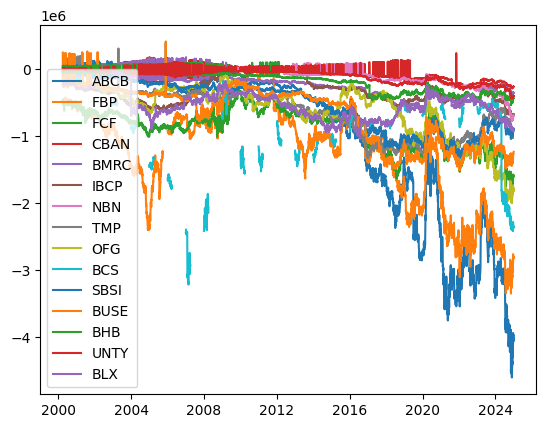

In [279]:
# plot all keys of Georisk_dict on the same plot and  the geo index with silver colour in another one below

# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
for ticker in Georisk_dict.keys():
    plt.plot(Georisk_dict[ticker], label=ticker)
    plt.legend()
# plt.subplot(2, 1, 2)
# plt.plot(Geo_Pol_index, color='silver', label='Geo-Political Index')
# plt.legend()
    

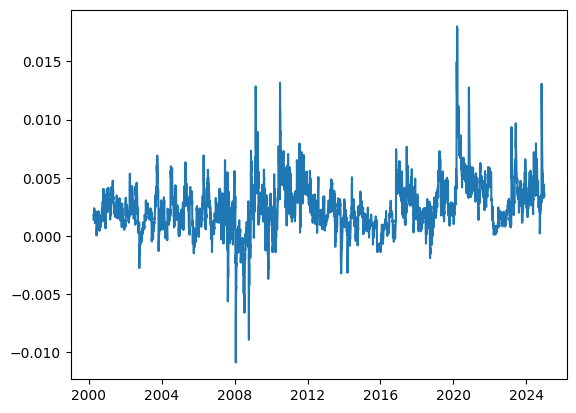

In [277]:
plt.plot(beta_i_geo['ABCB'])

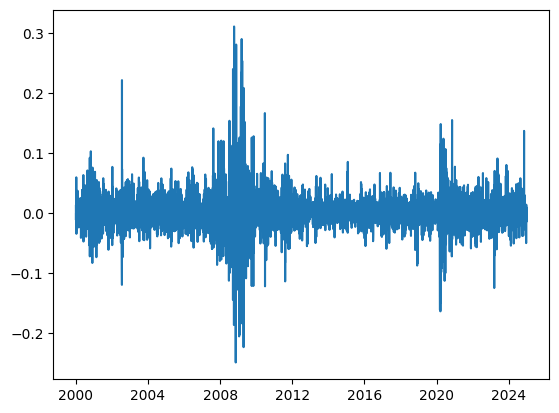

In [278]:
plt.plot(Bank_data_other['ABCB']['RET'])

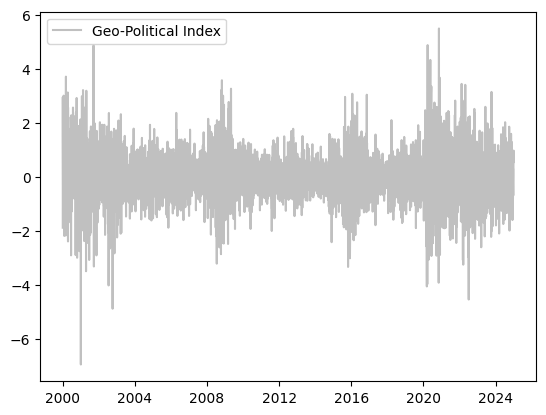

In [268]:
# plt.subplot(2, 1, 2)
plt.plot(Geo_Pol_index, color='silver', label='Geo-Political Index')
plt.legend()